In [ ]:
# 載入yolo
!git clone https://github.com/AlexeyAB/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 15833, done.
remote: Total 15833 (delta 0), reused 0 (delta 0), pack-reused 15833
Receiving objects: 100% (15833/15833), 14.35 MiB | 18.62 MiB/s, done.
Resolving deltas: 100% (10670/10670), done.


In [ ]:
# 切換到darknet資料夾
%cd ./darknet

/content/darknet


In [ ]:
%ls

3rdparty/       DarknetConfig.cmake.in  Dockerfile.cpu          LICENSE         scripts/
build/          darknet_images.py       Dockerfile.gpu          Makefile        src/
build.ps1*      darknet.py              image_yolov3.sh*        net_cam_v3.sh*  vcpkg.json
cfg/            darknet_video.py        image_yolov4.sh*        net_cam_v4.sh*  vcpkg.json.opencv23
cmake/          data/                   include/                package.xml     video_yolov3.sh*
CMakeLists.txt  docker-compose.yml      json_mjpeg_streams.sh*  README.md       video_yolov4.sh*


src/Makefile => 載入的設定檔

cfg => 各版本yolo設定檔

data/labels/coco.name => 預設的辨別種類

data => 圖檔，可用來測試

GPU 加速運算器

CUDNN=1 調用 cuDNNv5~v7加速訓練

CUDNN_HALF=1 調用 Tensor Cortes，偵測時會比原本的速度快三倍，訓練時快兩倍

OPENCV=1 調用 影像處理，攝影機等

LISBO=1 調用 darknet.so 編譯庫

In [ ]:
# 更改載入設定檔
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

In [ ]:
# 編譯
!make

mkdir -p ./obj/
mkdir -p backup
mkdir -p results
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:945:23: warning: variable ‘rgb’ set but not used []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wunused-but-set-variable-Wunused-but-set-variable]8;;]
  945 |                 float rgb[3];
      |                       ^~~
./src/image_opencv.cpp: In function ‘void cv_draw_object(image, float*, int, int, int*, float*, int*, int, char**)’:
./src/image_opencv.cpp:1443:

In [ ]:
# 載入權重
!wget https://pjreddie.com/media/files/yolov3.weights

--2024-02-22 11:50:56--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  36.1MB/s    in 8.5s    

2024-02-22 11:52:20 (27.8 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [ ]:
# 預測圖片 ./darknet 根目錄下的darknet資料夾 detect 偵測 cfg/yolov3.cfg 設定檔 yolov3.weights 權重(上面載入的權重位置) data/dog.jpg 要預測的圖片位置
!./darknet detect cfg/yolov3.cfg yolov3.weights data/k.jpg

 CUDA-version: 12020 (12020), cuDNN: 8.9.6, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.5.4
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595

603行 cfg/yolov3.cfg 中的 filters =255 => (80種+5)*3通道

固定算法 (C+5)*3

如更改種類，filters與classes數量都須被更改

In [ ]:
import cv2
import matplotlib.pyplot as plt
def imShow(img):
  image = cv2.imread(img)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image, (2*width, 2*height), interpolation=cv2.INTER_CUBIC) # interpolation 補差點(環迴增值法) =cv2.INTER_CUBIC 適用於圖片由小變大 (更平滑)
  fig = plt.gcf()
  fig.set_size_inches(16,10)
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

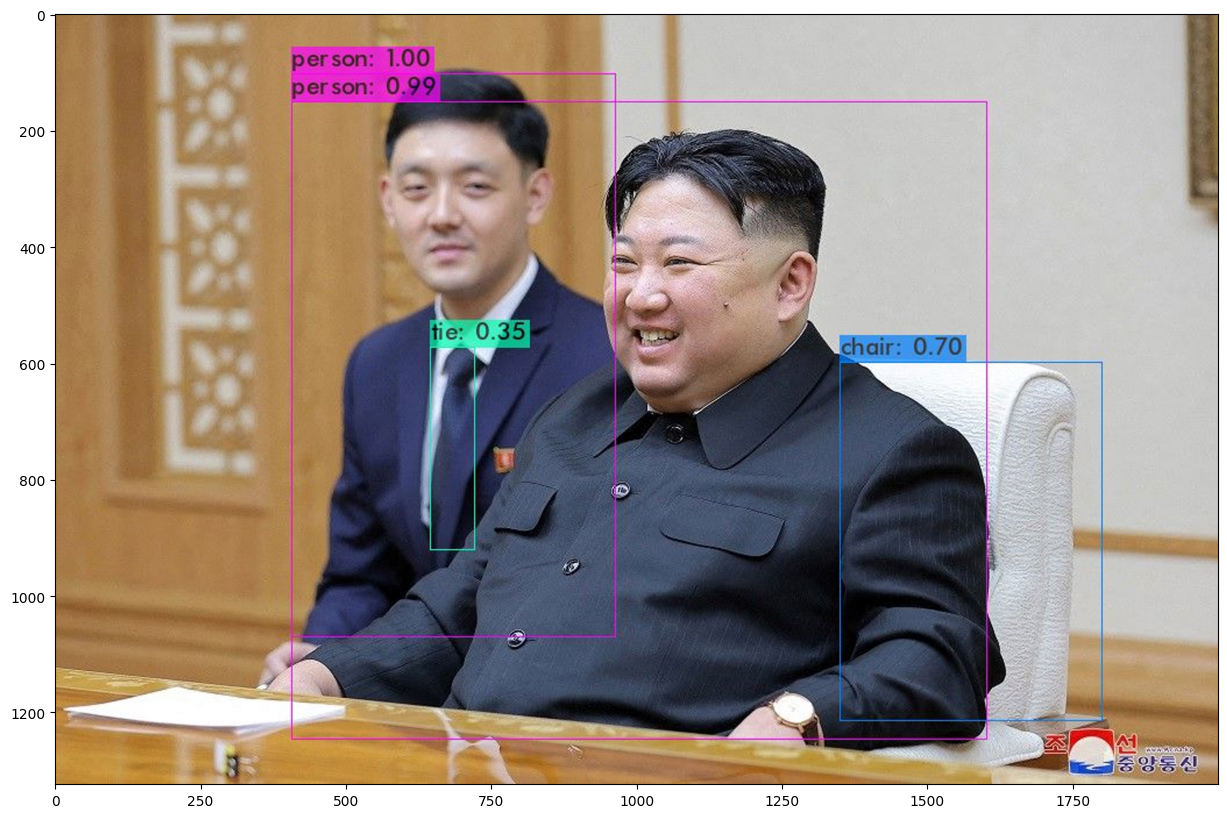

In [ ]:
imShow('predictions.jpg')

!./darknet detector test 圖片

!./darknet detector demo 影像

!./darknet detector train 訓練用

In [ ]:
#!./darknet detector demo 影像 cfg/coco.data 辨識資料 cfg/yolov3.cfg 設定檔 yolov3.weights 權重 pexels.mp4 影像位置 -out_filename 輸出檔名 result.avi 檔名 -dont_show 在執行中不顯示
!./darknet detector demo cfg/coco.data cfg/yolov3.cfg yolov3.weights pexels.mp4 -out_filename result.avi -dont_show
# 也可用別的版本的yolo，只是權重不同

串流輸出內容已截斷至最後 5000 行。
car: 52% 
car: 44% 
car: 44% 
car: 41% 
car: 38% 
car: 37% 
car: 31% 
car: 28% 
car: 27% 
car: 27% 

FPS:9.7 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

traffic light: 75% 
traffic light: 34% 
traffic light: 31% 
truck: 30% 
bus: 28% 
car: 98% 
car: 98% 
car: 96% 
car: 95% 
car: 93% 
car: 92% 
car: 91% 
car: 90% 
car: 87% 
car: 82% 
car: 81% 
car: 79% 
car: 77% 
car: 76% 
car: 75% 
car: 72% 
car: 71% 
car: 69% 
car: 63% 
car: 63% 
car: 62% 
car: 57% 
car: 57% 
car: 43% 
car: 42% 
car: 36% 
car: 36% 
car: 31% 
car: 30% 
car: 28% 

FPS:9.7 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

traffic light: 77% 
traffic light: 30% 
traffic light: 29% 
traffic light: 28% 
bus: 97% 
car: 98% 
car: 96% 
car: 96% 
car: 94% 
car: 94% 
car: 93% 
car: 93% 
car: 92% 
car: 90% 
car: 90% 
car: 89% 
car: 83% 
car: 80% 
car: 76% 
car: 73% 
car: 71% 
car: 65% 
car: 63% 
car: 63% 
car: 61% 
car: 61% 
car: 60% 
car: 58% 
car: 56% 
car: 54% 
car: 44% 
car: 38% 
car: 35% 
car: 31% 
car: 31% 
car: 30% 

In [ ]:
!./darknet detector demo cfg/coco.data cfg/yolov3.cfg yolov3.weights party.mp4 -out_filename party.avi -dont_show

 CUDA-version: 12020 (12020), cuDNN: 8.9.6, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.5.4
Demo
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 